# Charlottesville Open Data Porttal: Crime Data

## Import Relevant Librarires & Set WD

In [1]:
import requests
import pandas as pd
import numpy as np
import pickle
import googlemaps
import plotly.express as px
from geopy.geocoders import Nominatim
import time
from dotenv import load_dotenv
import os

env_path = os.path.join("..", ".env")
#print("Looking for .env file at:", os.path.abspath(env_path))
load_dotenv(dotenv_path=env_path)

# Retrieve the variables
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
WORKING_DIR = os.getenv("WORKING_DIR")

if GOOGLE_API_KEY is None or WORKING_DIR is None:
    raise RuntimeError("No configuration found. Please ensure that your .env file exists with the required variables, or create a local config.py file.")

#print("Google API Key:", GOOGLE_API_KEY)
#print("Working Directory:", WORKING_DIR)

## Import Data

URL: https://opendata.charlottesville.org/datasets/charlottesville::crime-data/about

In [2]:
# Define the endpoint and initial parameters.
url = "https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_2/MapServer/6/query"
params = {
    "where": "1=1",
    "outFields": "*",
    "outSR": 4326,
    "f": "json",
    "resultOffset": 0,       # Starting index for results
    "resultRecordCount": 10000  # Maximum records per batch (if allowed by the API)
}

records = []

while True:
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()
    
    # Get the current batch of features.
    features = data.get("features", [])
    if not features:
        break

    # Extract the attributes from the features.
    batch_records = [feature.get("attributes", {}) for feature in features]
    records.extend(batch_records)
    
    # If the batch size is less than the requested count, we reached the end.
    if len(features) < params["resultRecordCount"]:
        break

    # Update the resultOffset for the next batch.
    params["resultOffset"] += params["resultRecordCount"]

# Create a DataFrame from the combined records.
df = pd.DataFrame(records)
print("Total records imported:", len(df))


Total records imported: 25258


In [3]:
df.head()

,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,DateReported,HourReported,ReportingOfficer
0,1,Assist Citizen - Mental/TDO/ECO,202500013182,900,MONTICELLO AVE,CPD,1745368238000,2030,"Benbow, Lauren"
1,2,Larceny - All Other,202500013176,900,RIVES ST,CPD,1745362781000,1859,"Lowry, Brent"
2,3,Larceny - All Other,202500013166,100,LANKFORD AVE,CPD,1745361969000,1846,"Lowry, Brent"
3,4,Animal - Bite,202500013143,200,BURNET ST,CPD,1745351512000,1551,"Lowry, Brent"
4,5,Vandalism,202500013130,500,CLEVELAND AVE,CPD,1745345144000,1405,"Turner, Devon"


In [4]:
df.columns

Index(['RecordID', 'Offense', 'IncidentID', 'BlockNumber', 'StreetName',
       'Agency', 'DateReported', 'HourReported', 'ReportingOfficer'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25258 entries, 0 to 25257
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   RecordID          25258 non-null  int64 
 1   Offense           25258 non-null  object
 2   IncidentID        25258 non-null  object
 3   BlockNumber       25258 non-null  object
 4   StreetName        25258 non-null  object
 5   Agency            25258 non-null  object
 6   DateReported      25258 non-null  int64 
 7   HourReported      25258 non-null  object
 8   ReportingOfficer  25241 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.7+ MB


### Missing Values

In [6]:
def missing_percentage(df):
    """
    Returns a DataFrame with the count and percentage of missing values for each column.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        pd.DataFrame: A DataFrame with columns 'MissingCount' and 'MissingPercentage'.
    """
    total_rows = len(df)
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / total_rows) * 100
    
    result = pd.DataFrame({
        'MissingCount': missing_count,
        'MissingPercentage': missing_percent.round(2)
    })
    
    return result

# Example usage:
missing_info = missing_percentage(df)
print(missing_info)


                  MissingCount  MissingPercentage
RecordID                     0               0.00
Offense                      0               0.00
IncidentID                   0               0.00
BlockNumber                  0               0.00
StreetName                   0               0.00
Agency                       0               0.00
DateReported                 0               0.00
HourReported                 0               0.00
ReportingOfficer            17               0.07


## Data Preparation

### Data Conversion

In [7]:
def convert_and_categorize_datereported(df, col='DateReported'):
    """
    Converts an epoch (in milliseconds) date column into a timezone-aware datetime,
    converts it to Eastern Time, and then creates columns for day-of-week, weekend flag,
    season, 12-hour formatted time, and time-of-day. Keeps both a real datetime column
    (Date) and a string representation (DateString).
    """
    import pandas as pd

    # Convert the epoch timestamp to a pandas datetime object as UTC, then convert to US/Eastern.
    df["DateReported_dt"] = (
        pd.to_datetime(df[col], unit="ms", errors="coerce", utc=True)
        .dt.tz_convert("US/Eastern")
    )
    
    # Create a true datetime column (remove timezone if you prefer naive datetime)
    df["Date"] = df["DateReported_dt"].dt.tz_localize(None)

    # Optionally, create a separate string-formatted column
    df["DateString"] = df["DateReported_dt"].dt.strftime("%Y-%m-%d %I:%M:%S %p")
    
    # DayOfWeek
    df["DayOfWeek"] = df["DateReported_dt"].dt.day_name()
    
    # Weekend
    df["Weekend"] = df["DayOfWeek"].isin(["Saturday", "Sunday"])
    
    # Helper function to determine the season
    def get_season(dt):
        month = dt.month
        day = dt.day
        # Approximate Northern Hemisphere season boundaries:
        if (month == 12 and day >= 21) or (month < 3) or (month == 3 and day < 20):
            return "Winter"
        elif (month == 3 and day >= 20) or (month < 6) or (month == 6 and day < 21):
            return "Spring"
        elif (month == 6 and day >= 21) or (month < 9) or (month == 9 and day < 22):
            return "Summer"
        else:
            return "Autumn"
    
    df["Season"] = df["DateReported_dt"].apply(get_season)
    
    # 12-hour formatted time (HourAMPM)
    df["HourAMPM"] = df["DateReported_dt"].dt.strftime("%I:%M %p")
    
    # Extract hour (0-23) for time-of-day
    df["HourValue"] = df["DateReported_dt"].dt.hour
    
    def time_of_day(hour):
        if pd.isnull(hour):
            return None
        if 5 <= hour < 12:
            return "Morning"
        elif 12 <= hour < 17:
            return "Afternoon"
        elif 17 <= hour < 21:
            return "Evening"
        else:
            return "Night"
    
    df["TimeOfDay"] = df["HourValue"].apply(time_of_day)
    
    # Drop columns you no longer need
    df.drop(columns=[col, "DateReported_dt", "HourValue"], inplace=True)
    
    return df

# Example usage:
df = convert_and_categorize_datereported(df)
df.head()


,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,HourReported,ReportingOfficer,Date,DateString,DayOfWeek,Weekend,Season,HourAMPM,TimeOfDay
0,1,Assist Citizen - Mental/TDO/ECO,202500013182,900,MONTICELLO AVE,CPD,2030,"Benbow, Lauren",2025-04-22 20:30:38,2025-04-22 08:30:38 PM,Tuesday,False,Spring,08:30 PM,Evening
1,2,Larceny - All Other,202500013176,900,RIVES ST,CPD,1859,"Lowry, Brent",2025-04-22 18:59:41,2025-04-22 06:59:41 PM,Tuesday,False,Spring,06:59 PM,Evening
2,3,Larceny - All Other,202500013166,100,LANKFORD AVE,CPD,1846,"Lowry, Brent",2025-04-22 18:46:09,2025-04-22 06:46:09 PM,Tuesday,False,Spring,06:46 PM,Evening
3,4,Animal - Bite,202500013143,200,BURNET ST,CPD,1551,"Lowry, Brent",2025-04-22 15:51:52,2025-04-22 03:51:52 PM,Tuesday,False,Spring,03:51 PM,Afternoon
4,5,Vandalism,202500013130,500,CLEVELAND AVE,CPD,1405,"Turner, Devon",2025-04-22 14:05:44,2025-04-22 02:05:44 PM,Tuesday,False,Spring,02:05 PM,Afternoon


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25258 entries, 0 to 25257
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   RecordID          25258 non-null  int64         
 1   Offense           25258 non-null  object        
 2   IncidentID        25258 non-null  object        
 3   BlockNumber       25258 non-null  object        
 4   StreetName        25258 non-null  object        
 5   Agency            25258 non-null  object        
 6   HourReported      25258 non-null  object        
 7   ReportingOfficer  25241 non-null  object        
 8   Date              25258 non-null  datetime64[ns]
 9   DateString        25258 non-null  object        
 10  DayOfWeek         25258 non-null  object        
 11  Weekend           25258 non-null  bool          
 12  Season            25258 non-null  object        
 13  HourAMPM          25258 non-null  object        
 14  TimeOfDay         2525

### Coordinates

In [9]:
# Combine BlockNumber and StreetName into a full address string
df['FullStreet'] = df['BlockNumber'].astype(str) + " " + df['StreetName']

# --- Step 1: Setup the Google Maps Client and Cache ---
gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

# Try to load cached geocoding results if available.
try:
    with open("geocode_cache_google.pkl", "rb") as f:
        street_coords = pickle.load(f)
    print("Loaded geocode cache.")
except FileNotFoundError:
    street_coords = {}
    print("No cache found; starting fresh.")

def geocode_address(address):
    try:
        # Append city and state to help geocoding
        result = gmaps.geocode(f"{address}, Charlottesville, VA")
        if result:
            lat = result[0]['geometry']['location']['lat']
            lon = result[0]['geometry']['location']['lng']
            return lat, lon
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
    return None, None

# --- Step 2: Geocode Only New Addresses ---
unique_addresses = df['FullStreet'].unique()
for address in unique_addresses:
    if address not in street_coords:
        lat, lon = geocode_address(address)
        street_coords[address] = (lat, lon)
        print(f"Geocoded {address}: {lat}, {lon}")

# Save the updated cache to disk.
with open("geocode_cache_google.pkl", "wb") as f:
    pickle.dump(street_coords, f)
    print("Geocode cache updated and saved.")

# --- Step 3: Map Coordinates Back to DataFrame ---
df['lat'] = df['FullStreet'].map(lambda s: street_coords.get(s, (None, None))[0])
df['lon'] = df['FullStreet'].map(lambda s: street_coords.get(s, (None, None))[1])

df.head()

Loaded geocode cache.


Geocoded 1900 E MARKET ST: 38.02163410000001, -78.4563391
Geocode cache updated and saved.


,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,HourReported,ReportingOfficer,Date,DateString,DayOfWeek,Weekend,Season,HourAMPM,TimeOfDay,FullStreet,lat,lon
0,1,Assist Citizen - Mental/TDO/ECO,202500013182,900,MONTICELLO AVE,CPD,2030,"Benbow, Lauren",2025-04-22 20:30:38,2025-04-22 08:30:38 PM,Tuesday,False,Spring,08:30 PM,Evening,900 MONTICELLO AVE,38.022670,-78.475939
1,2,Larceny - All Other,202500013176,900,RIVES ST,CPD,1859,"Lowry, Brent",2025-04-22 18:59:41,2025-04-22 06:59:41 PM,Tuesday,False,Spring,06:59 PM,Evening,900 RIVES ST,38.017740,-78.469803
2,3,Larceny - All Other,202500013166,100,LANKFORD AVE,CPD,1846,"Lowry, Brent",2025-04-22 18:46:09,2025-04-22 06:46:09 PM,Tuesday,False,Spring,06:46 PM,Evening,100 LANKFORD AVE,38.021311,-78.487056
3,4,Animal - Bite,202500013143,200,BURNET ST,CPD,1551,"Lowry, Brent",2025-04-22 15:51:52,2025-04-22 03:51:52 PM,Tuesday,False,Spring,03:51 PM,Afternoon,200 BURNET ST,38.025060,-78.487269
4,5,Vandalism,202500013130,500,CLEVELAND AVE,CPD,1405,"Turner, Devon",2025-04-22 14:05:44,2025-04-22 02:05:44 PM,Tuesday,False,Spring,02:05 PM,Afternoon,500 CLEVELAND AVE,38.017032,-78.498393


### Neighborhood

In [10]:
# Initialize the Google Maps client.
gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

# Try to load a persistent neighborhood cache if available.
try:
    with open("neighborhood_cache.pkl", "rb") as f:
        neighborhood_cache = pickle.load(f)
    print("Loaded neighborhood cache.")
except FileNotFoundError:
    neighborhood_cache = {}
    print("No neighborhood cache found; starting fresh.")

def get_neighborhood(lat, lon):
    """
    Reverse geocodes a latitude and longitude to retrieve the neighborhood.
    Caches results to speed up subsequent lookups.
    """
    key = (lat, lon)
    if key in neighborhood_cache:
        return neighborhood_cache[key]
    
    try:
        result = gmaps.reverse_geocode((lat, lon))
        if result:
            # Look for the 'neighborhood' component in the first result.
            for component in result[0]['address_components']:
                if 'neighborhood' in component['types']:
                    neighborhood = component['long_name']
                    neighborhood_cache[key] = neighborhood
                    return neighborhood
            # If no neighborhood is found, return "N/A"
            neighborhood_cache[key] = "N/A"
            return "N/A"
    except Exception as e:
        print(f"Error getting neighborhood for {lat}, {lon}: {e}")
        return "N/A"
    
    # Pause to respect usage limits.
    time.sleep(1)

# Example usage: Apply to your DataFrame 'df' that already has 'lat' and 'lon' columns.
df['neighborhood'] = df.apply(lambda row: get_neighborhood(row['lat'], row['lon']), axis=1)

# Save the updated neighborhood cache.
with open("neighborhood_cache.pkl", "wb") as f:
    pickle.dump(neighborhood_cache, f)

df.head()


Loaded neighborhood cache.


,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,HourReported,ReportingOfficer,Date,DateString,DayOfWeek,Weekend,Season,HourAMPM,TimeOfDay,FullStreet,lat,lon,neighborhood
0,1,Assist Citizen - Mental/TDO/ECO,202500013182,900,MONTICELLO AVE,CPD,2030,"Benbow, Lauren",2025-04-22 20:30:38,2025-04-22 08:30:38 PM,Tuesday,False,Spring,08:30 PM,Evening,900 MONTICELLO AVE,38.022670,-78.475939,Belmont
1,2,Larceny - All Other,202500013176,900,RIVES ST,CPD,1859,"Lowry, Brent",2025-04-22 18:59:41,2025-04-22 06:59:41 PM,Tuesday,False,Spring,06:59 PM,Evening,900 RIVES ST,38.017740,-78.469803,Belmont
2,3,Larceny - All Other,202500013166,100,LANKFORD AVE,CPD,1846,"Lowry, Brent",2025-04-22 18:46:09,2025-04-22 06:46:09 PM,Tuesday,False,Spring,06:46 PM,Evening,100 LANKFORD AVE,38.021311,-78.487056,Ridge St.
3,4,Animal - Bite,202500013143,200,BURNET ST,CPD,1551,"Lowry, Brent",2025-04-22 15:51:52,2025-04-22 03:51:52 PM,Tuesday,False,Spring,03:51 PM,Afternoon,200 BURNET ST,38.025060,-78.487269,Ridge St.
4,5,Vandalism,202500013130,500,CLEVELAND AVE,CPD,1405,"Turner, Devon",2025-04-22 14:05:44,2025-04-22 02:05:44 PM,Tuesday,False,Spring,02:05 PM,Afternoon,500 CLEVELAND AVE,38.017032,-78.498393,Johnson Village


### Zip

In [11]:
# Initialize the geocoder.
geolocator = Nominatim(user_agent="zip_lookup")

# Try to load a persistent ZIP cache if available.
try:
    with open("zip_cache.pkl", "rb") as f:
        zip_cache = pickle.load(f)
    print("Loaded zip cache.")
except FileNotFoundError:
    zip_cache = {}
    print("No zip cache found; starting fresh.")

def get_zip(lat, lon):
    """
    Reverse geocodes a latitude and longitude to retrieve the ZIP code.
    Caches results to speed up subsequent lookups.
    """
    key = (lat, lon)
    if key in zip_cache:
        return zip_cache[key]
    
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        address = location.raw.get('address', {})
        postal_code = address.get('postcode', "N/A")
    except Exception as e:
        print(f"Error getting ZIP for {lat}, {lon}: {e}")
        postal_code = "N/A"
    
    zip_cache[key] = postal_code
    # Pause to respect the usage policy.
    time.sleep(1)
    return postal_code

# Apply the function to each row in the DataFrame.
df['zip'] = df.apply(lambda row: get_zip(row['lat'], row['lon']), axis=1)

# Save the updated ZIP cache.
with open("zip_cache.pkl", "wb") as f:
    pickle.dump(zip_cache, f)

df.head()


Loaded zip cache.


,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,HourReported,ReportingOfficer,Date,DateString,DayOfWeek,Weekend,Season,HourAMPM,TimeOfDay,FullStreet,lat,lon,neighborhood,zip
0,1,Assist Citizen - Mental/TDO/ECO,202500013182,900,MONTICELLO AVE,CPD,2030,"Benbow, Lauren",2025-04-22 20:30:38,2025-04-22 08:30:38 PM,Tuesday,False,Spring,08:30 PM,Evening,900 MONTICELLO AVE,38.022670,-78.475939,Belmont,22903
1,2,Larceny - All Other,202500013176,900,RIVES ST,CPD,1859,"Lowry, Brent",2025-04-22 18:59:41,2025-04-22 06:59:41 PM,Tuesday,False,Spring,06:59 PM,Evening,900 RIVES ST,38.017740,-78.469803,Belmont,22902
2,3,Larceny - All Other,202500013166,100,LANKFORD AVE,CPD,1846,"Lowry, Brent",2025-04-22 18:46:09,2025-04-22 06:46:09 PM,Tuesday,False,Spring,06:46 PM,Evening,100 LANKFORD AVE,38.021311,-78.487056,Ridge St.,22903
3,4,Animal - Bite,202500013143,200,BURNET ST,CPD,1551,"Lowry, Brent",2025-04-22 15:51:52,2025-04-22 03:51:52 PM,Tuesday,False,Spring,03:51 PM,Afternoon,200 BURNET ST,38.025060,-78.487269,Ridge St.,22902
4,5,Vandalism,202500013130,500,CLEVELAND AVE,CPD,1405,"Turner, Devon",2025-04-22 14:05:44,2025-04-22 02:05:44 PM,Tuesday,False,Spring,02:05 PM,Afternoon,500 CLEVELAND AVE,38.017032,-78.498393,Johnson Village,22903


In [12]:
missing_info = missing_percentage(df)
print(missing_info)


                  MissingCount  MissingPercentage
RecordID                     0               0.00
Offense                      0               0.00
IncidentID                   0               0.00
BlockNumber                  0               0.00
StreetName                   0               0.00
Agency                       0               0.00
HourReported                 0               0.00
ReportingOfficer            17               0.07
Date                         0               0.00
DateString                   0               0.00
DayOfWeek                    0               0.00
Weekend                      0               0.00
Season                       0               0.00
HourAMPM                     0               0.00
TimeOfDay                    0               0.00
FullStreet                   0               0.00
lat                          0               0.00
lon                          0               0.00
neighborhood                 0               0.00


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25258 entries, 0 to 25257
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   RecordID          25258 non-null  int64         
 1   Offense           25258 non-null  object        
 2   IncidentID        25258 non-null  object        
 3   BlockNumber       25258 non-null  object        
 4   StreetName        25258 non-null  object        
 5   Agency            25258 non-null  object        
 6   HourReported      25258 non-null  object        
 7   ReportingOfficer  25241 non-null  object        
 8   Date              25258 non-null  datetime64[ns]
 9   DateString        25258 non-null  object        
 10  DayOfWeek         25258 non-null  object        
 11  Weekend           25258 non-null  bool          
 12  Season            25258 non-null  object        
 13  HourAMPM          25258 non-null  object        
 14  TimeOfDay         2525

In [14]:
# Now drop the original BlockNumber and StreetName columns
df.drop(columns=['BlockNumber', 'StreetName','HourAMPM','HourReported','DateString'], inplace=True)
df["zip"] = df["zip"].astype(str)

# Fill all missing values in the DataFrame with "N/A"
df.replace({None: "N/A", np.nan: "N/A", "": "N/A"}, inplace=True)
df.head()

,RecordID,Offense,IncidentID,Agency,ReportingOfficer,Date,DayOfWeek,Weekend,Season,TimeOfDay,FullStreet,lat,lon,neighborhood,zip
0,1,Assist Citizen - Mental/TDO/ECO,202500013182,CPD,"Benbow, Lauren",2025-04-22 20:30:38,Tuesday,False,Spring,Evening,900 MONTICELLO AVE,38.022670,-78.475939,Belmont,22903
1,2,Larceny - All Other,202500013176,CPD,"Lowry, Brent",2025-04-22 18:59:41,Tuesday,False,Spring,Evening,900 RIVES ST,38.017740,-78.469803,Belmont,22902
2,3,Larceny - All Other,202500013166,CPD,"Lowry, Brent",2025-04-22 18:46:09,Tuesday,False,Spring,Evening,100 LANKFORD AVE,38.021311,-78.487056,Ridge St.,22903
3,4,Animal - Bite,202500013143,CPD,"Lowry, Brent",2025-04-22 15:51:52,Tuesday,False,Spring,Afternoon,200 BURNET ST,38.025060,-78.487269,Ridge St.,22902
4,5,Vandalism,202500013130,CPD,"Turner, Devon",2025-04-22 14:05:44,Tuesday,False,Spring,Afternoon,500 CLEVELAND AVE,38.017032,-78.498393,Johnson Village,22903


In [15]:
missing_info = missing_percentage(df)
print(missing_info)

                  MissingCount  MissingPercentage
RecordID                     0                0.0
Offense                      0                0.0
IncidentID                   0                0.0
Agency                       0                0.0
ReportingOfficer             0                0.0
Date                         0                0.0
DayOfWeek                    0                0.0
Weekend                      0                0.0
Season                       0                0.0
TimeOfDay                    0                0.0
FullStreet                   0                0.0
lat                          0                0.0
lon                          0                0.0
neighborhood                 0                0.0
zip                          0                0.0


In [16]:
df.columns

Index(['RecordID', 'Offense', 'IncidentID', 'Agency', 'ReportingOfficer',
       'Date', 'DayOfWeek', 'Weekend', 'Season', 'TimeOfDay', 'FullStreet',
       'lat', 'lon', 'neighborhood', 'zip'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25258 entries, 0 to 25257
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   RecordID          25258 non-null  int64         
 1   Offense           25258 non-null  object        
 2   IncidentID        25258 non-null  object        
 3   Agency            25258 non-null  object        
 4   ReportingOfficer  25258 non-null  object        
 5   Date              25258 non-null  datetime64[ns]
 6   DayOfWeek         25258 non-null  object        
 7   Weekend           25258 non-null  bool          
 8   Season            25258 non-null  object        
 9   TimeOfDay         25258 non-null  object        
 10  FullStreet        25258 non-null  object        
 11  lat               25258 non-null  float64       
 12  lon               25258 non-null  float64       
 13  neighborhood      25258 non-null  object        
 14  zip               2525

### Export Clean Data

In [18]:
# Determine the project root (assuming papermill is run from the repository root)
project_root = os.getcwd()
print("Project Root:", project_root)

# Set the data directory within the project root
data_dir = os.path.join(project_root, "data")

# Ensure the "data" directory exists (create it if it doesn't)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Export the DataFrame to CSV in the "data" folder located in the project root
csv_path = os.path.join(data_dir, "charlottesville_crime_incidents.csv")
df.to_csv(csv_path, index=False)
print("Data saved to:", csv_path)

# Construct the path to your Excel file
excel_path = os.path.join(data_dir, "charlottesville_crime_incidents.xlsx")

# Export the DataFrame to Excel
df.to_excel(excel_path, index=False)
print("Excel saved to:", excel_path)


Project Root: /home/runner/work/crime-data/crime-data


Data saved to: /home/runner/work/crime-data/crime-data/data/charlottesville_crime_incidents.csv


Excel saved to: /home/runner/work/crime-data/crime-data/data/charlottesville_crime_incidents.xlsx


## Predictive Analytics

In [19]:
df.head()

,RecordID,Offense,IncidentID,Agency,ReportingOfficer,Date,DayOfWeek,Weekend,Season,TimeOfDay,FullStreet,lat,lon,neighborhood,zip
0,1,Assist Citizen - Mental/TDO/ECO,202500013182,CPD,"Benbow, Lauren",2025-04-22 20:30:38,Tuesday,False,Spring,Evening,900 MONTICELLO AVE,38.022670,-78.475939,Belmont,22903
1,2,Larceny - All Other,202500013176,CPD,"Lowry, Brent",2025-04-22 18:59:41,Tuesday,False,Spring,Evening,900 RIVES ST,38.017740,-78.469803,Belmont,22902
2,3,Larceny - All Other,202500013166,CPD,"Lowry, Brent",2025-04-22 18:46:09,Tuesday,False,Spring,Evening,100 LANKFORD AVE,38.021311,-78.487056,Ridge St.,22903
3,4,Animal - Bite,202500013143,CPD,"Lowry, Brent",2025-04-22 15:51:52,Tuesday,False,Spring,Afternoon,200 BURNET ST,38.025060,-78.487269,Ridge St.,22902
4,5,Vandalism,202500013130,CPD,"Turner, Devon",2025-04-22 14:05:44,Tuesday,False,Spring,Afternoon,500 CLEVELAND AVE,38.017032,-78.498393,Johnson Village,22903


In [20]:
df.columns

Index(['RecordID', 'Offense', 'IncidentID', 'Agency', 'ReportingOfficer',
       'Date', 'DayOfWeek', 'Weekend', 'Season', 'TimeOfDay', 'FullStreet',
       'lat', 'lon', 'neighborhood', 'zip'],
      dtype='object')

### Data Preparation

We need to ensure the data is in the correct format for modeling and can handle missing values, categorical variables, and dates. Here's how to prepare your data:

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Feature engineering: Extract additional time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfMonth'] = df['Date'].dt.day

# One-hot encoding for 'FullStreet', 'neighborhood', 'zip'
df = pd.get_dummies(df, columns=['FullStreet', 'neighborhood', 'zip'], drop_first=True)

# Label encoding for ordered variables (those with a natural order like 'DayOfWeek', 'Season', 'TimeOfDay')
label_encoders = {}
for column in ['DayOfWeek', 'Season', 'TimeOfDay', 'Agency', 'ReportingOfficer']:  # Example ordinal variables
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Filter the dataset to include only the offenses of interest
offenses_of_interest = [
    'Hit and Run', 'Assault Simple', 'Suspicious Activity', 'Vandalism', 
    'Larceny - From Mot Vehicle', 'Larceny - All Other', 
    'Assist Citizen - Mental/TDO/ECO', 'Lost/FoundProperty'
]

df = df[df['Offense'].isin(offenses_of_interest)]

# Label encode the target variable (Offense)
offense_encoder = LabelEncoder()
df['Offense'] = offense_encoder.fit_transform(df['Offense'])

# Separate features (X) and target (y)
X = df[['Year', 'Month', 'DayOfMonth', 'DayOfWeek', 'Weekend', 'Season', 'TimeOfDay', 'lat', 'lon', 'Agency', 'ReportingOfficer']]
y = df['Offense']  # Offense is now the encoded target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Model Training

Here we will train several models (e.g., Random Forest, Logistic Regression, and Decision Tree). We will use cross-validation to choose the best model based on accuracy, and then explain the impact of the variables.

/opt/hostedtoolcache/Python/3.9.22/x64/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/hostedtoolcache/Python/3.9.22/x64/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/hostedtoolcache/Python/3.9.22/x64/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedM


Classification Report for All Models:

Model: RandomForest
Accuracy: 0.2874
              precision    recall  f1-score      support
0              0.293447  0.357639  0.322379   576.000000
1              0.261972  0.232500  0.246358   400.000000
2              0.316456  0.477941  0.380785   680.000000
3              0.230337  0.175589  0.199271   467.000000
4              0.282700  0.199405  0.233857   336.000000
5              0.281013  0.209434  0.240000   530.000000
6              0.284264  0.234801  0.257176   477.000000
accuracy       0.287363  0.287363  0.287363     0.287363
macro avg      0.278598  0.269615  0.268546  3466.000000
weighted avg   0.281618  0.287363  0.278325  3466.000000


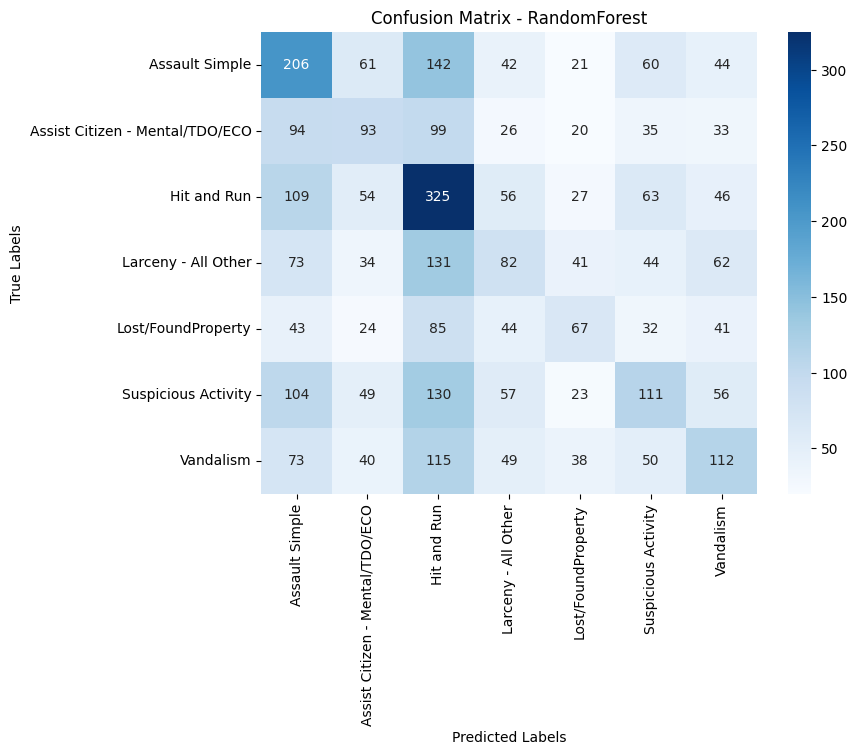


Model: LogisticRegression
Accuracy: 0.2129
              precision    recall  f1-score      support
0              0.204512  0.487847  0.288205   576.000000
1              0.000000  0.000000  0.000000   400.000000
2              0.218451  0.672059  0.329726   680.000000
3              0.000000  0.000000  0.000000   467.000000
4              0.000000  0.000000  0.000000   336.000000
5              0.000000  0.000000  0.000000   530.000000
6              0.000000  0.000000  0.000000   477.000000
accuracy       0.212926  0.212926  0.212926     0.212926
macro avg      0.060423  0.165701  0.088276  3466.000000
weighted avg   0.076845  0.212926  0.112585  3466.000000


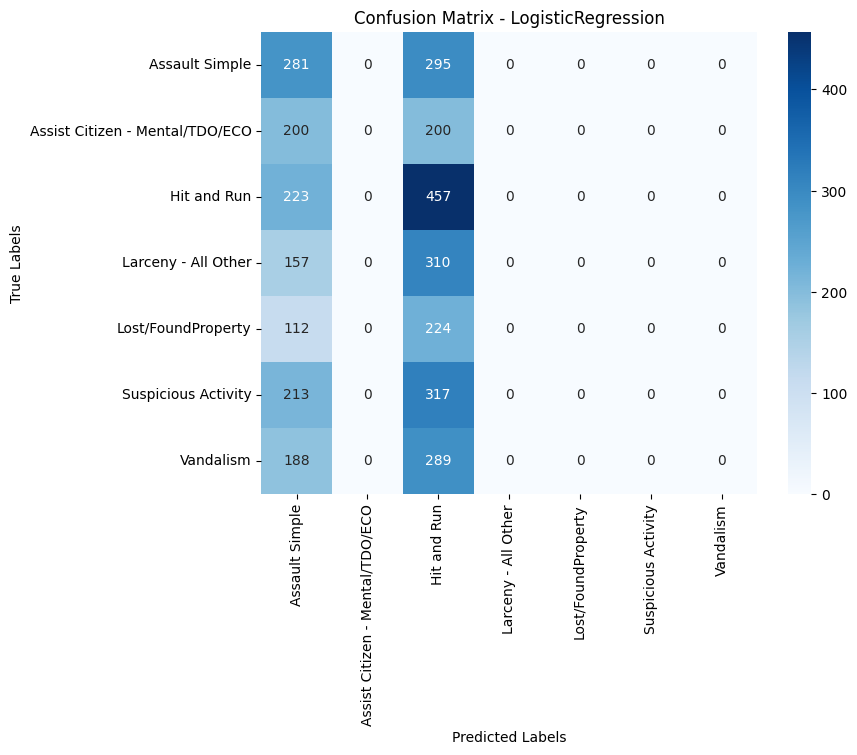


Model: DecisionTree
Accuracy: 0.2325
              precision    recall  f1-score      support
0              0.248629  0.236111  0.242208   576.000000
1              0.246220  0.285000  0.264195   400.000000
2              0.304560  0.275000  0.289026   680.000000
3              0.197938  0.205567  0.201681   467.000000
4              0.175000  0.187500  0.181034   336.000000
5              0.209677  0.196226  0.202729   530.000000
6              0.211577  0.222222  0.216769   477.000000
accuracy       0.232545  0.232545  0.232545     0.232545
macro avg      0.227657  0.229661  0.228235  3466.000000
weighted avg   0.234301  0.232545  0.233002  3466.000000


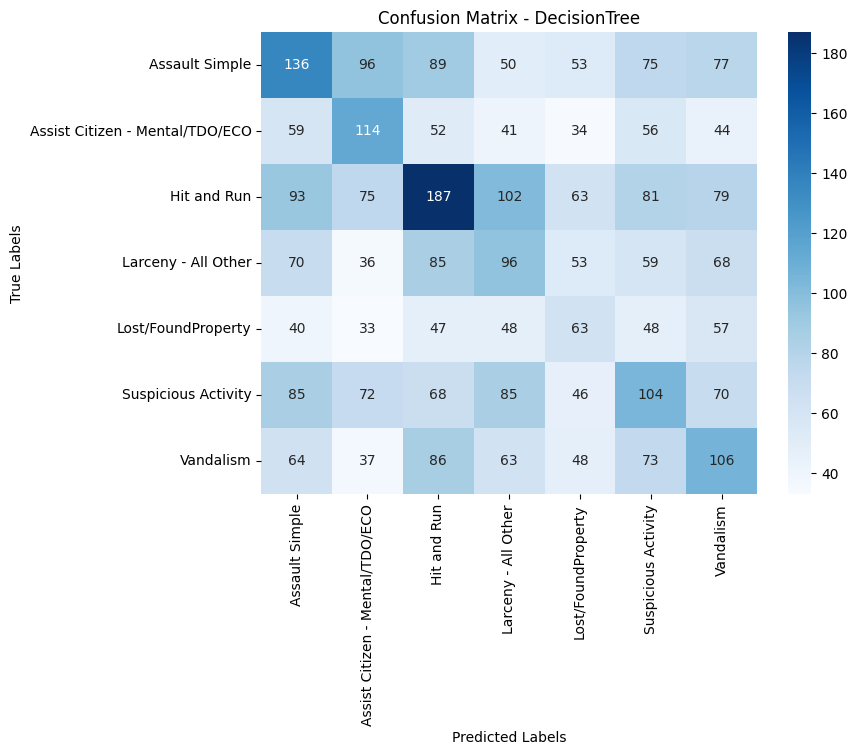


Best Model:
Best Model: RandomForestClassifier()
Best Model Accuracy: 0.2874


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define models
models = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier()
}

# Train models and evaluate them
best_model = None
best_score = 0
model_reports = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Make predictions
    
    # Calculate accuracy and generate classification report
    accuracy = accuracy_score(y_test, y_pred)
    model_reports[model_name] = classification_report(y_test, y_pred, output_dict=True)  # Store as a dictionary for easier analysis
    
    # Track best performing model
    if accuracy > best_score:
        best_score = accuracy
        best_model = model

# Display classification reports and confusion matrices
print("\nClassification Report for All Models:")
for model_name, report in model_reports.items():
    print(f"\nModel: {model_name}")
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, models[model_name].predict(X_test))))  # Display accuracy
    print(pd.DataFrame(report).transpose())  # Display classification report as a DataFrame

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, models[model_name].predict(X_test))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=offense_encoder.classes_, yticklabels=offense_encoder.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Display best model details
print("\nBest Model:")
print(f"Best Model: {best_model}")
print(f"Best Model Accuracy: {best_score:.4f}")


#### Classification Report for All Models:

### Explanation of the Classification Results (RandomForest Model)

The results you provided are from a **Random Forest** model, which is used for predicting different types of offenses. Let's break down the key components of the results:

#### 1. **Accuracy: 0.2822**
   - **Accuracy** measures the overall percentage of correct predictions made by the model. An accuracy of 28.22% means the model correctly predicted the offense in about 28% of the cases. This indicates the model's predictions are not highly reliable, as the accuracy is quite low.

#### 2. **Classification Report:**
   The classification report includes precision, recall, and F1-score for each offense. Let's go over these terms and how they apply to the results:

   - **Precision**: The proportion of true positive predictions out of all positive predictions made by the model for a specific class (offense).
   - **Recall**: The proportion of true positive predictions out of all actual positive instances in the dataset.
   - **F1-Score**: The harmonic mean of precision and recall, providing a balance between the two metrics.
   - **Support**: The number of actual occurrences of each class in the test set.

   Let's analyze each offense based on these metrics:

   | **Offense**                        | **Precision** | **Recall** | **F1-Score** | **Support** |
   |------------------------------------|---------------|------------|--------------|-------------|
   | **Assault Simple**                 | 0.2892        | 0.3754     | 0.3267       | 594         |
   | **Assist Citizen - Mental/TDO/ECO**| 0.3182        | 0.2274     | 0.2652       | 431         |
   | **Hit and Run**                    | 0.2963        | 0.4765     | 0.3654       | 638         |
   | **Larceny - All Other**            | 0.2270        | 0.1453     | 0.1772       | 475         |
   | **Lost/FoundProperty**             | 0.3333        | 0.2102     | 0.2578       | 352         |
   | **Suspicious Activity**            | 0.2344        | 0.2169     | 0.2253       | 484         |
   | **Vandalism**                      | 0.2712        | 0.2106     | 0.2371       | 470         |

#### 3. **Key Insights from the Report:**

- **Precision**:
   - The highest precision is for **Larceny - All Other** (0.3333), indicating that when the model predicts this offense, it is correct about 33% of the time. However, this is still quite low.
   - **Assist Citizen - Mental/TDO/ECO** has the lowest precision (0.2269), meaning that the model's predictions for this offense tend to be wrong more often than correct.

- **Recall**:
   - **Hit and Run** has the highest recall (0.4765), meaning the model identifies about 48% of the actual occurrences of this offense. This is better than the precision, which indicates it is missing many true positives but is still able to identify a fair number of cases.
   - **Larceny - All Other** and **Suspicious Activity** have the lowest recall values (0.1453 and 0.2169, respectively), indicating that the model is failing to identify most of the actual cases for these offenses.

- **F1-Score**:
   - The **F1-Score** balances precision and recall. It is highest for **Hit and Run** (0.3654), but still relatively low overall. This suggests the model is better at identifying **Hit and Run** than other offenses but still has room for improvement.
   - **Larceny - All Other** has the lowest F1-Score (0.1772), indicating a poor balance between precision and recall for this offense.

#### 4. **Macro Average and Weighted Average:**
   - **Macro Average**: This gives the average precision, recall, and F1-Score across all classes (offenses) without considering the class distribution. It averages the results for all offenses equally.
     - Precision: 0.2814
     - Recall: 0.2661
     - F1-Score: 0.2649
   - **Weighted Average**: This averages the metrics but weighs each class by its support (the number of true instances in the test set). This gives a better sense of overall performance, considering the class distribution.
     - Precision: 0.2799
     - Recall: 0.2822
     - F1-Score: 0.2720

#### 5. **Confusion Matrix (Visualization Analysis)**:
   - The confusion matrix shows the distribution of true positive, false positive, true negative, and false negative predictions for each class.
     - For **Hit and Run**, the model performs relatively well in identifying this offense (304 true positives). However, it also misclassifies some **Hit and Run** instances as other offenses (e.g., **Assault Simple**, **Suspicious Activity**, etc.).
     - **Larceny - All Other** is frequently misclassified as **Hit and Run**, **Suspicious Activity**, and others. This is evident from the large number of off-diagonal elements in its row.
     - **Assist Citizen - Mental/TDO/ECO** and **Suspicious Activity** are frequently misclassified, as seen by the off-diagonal values in their rows.

### Conclusion:
The Random Forest model has low accuracy (28.22%), suggesting that it struggles to predict most offenses accurately. Some offenses like **Hit and Run** are better predicted than others, but overall, the model shows a high level of misclassification across all offenses. There may be a need for further tuning of the model, additional feature engineering, or trying different models for better performance.

Let me know if you'd like to improve the model or make adjustments based on these results!



### Model Explanation

Once we’ve chosen the best model, we will explain its predictions by examining feature importance for tree-based models and using statistical methods like logistic regression coefficients for linear models.

#### Feature Importance for Random Forest / Decision Tree

##### For Tree-based Models (Random Forest, Decision Tree)

For Random Forest or Decision Tree, we can look at feature importance to understand which variables contribute the most to the model's predictions. Here's how you can visualize and interpret the importance of each feature:

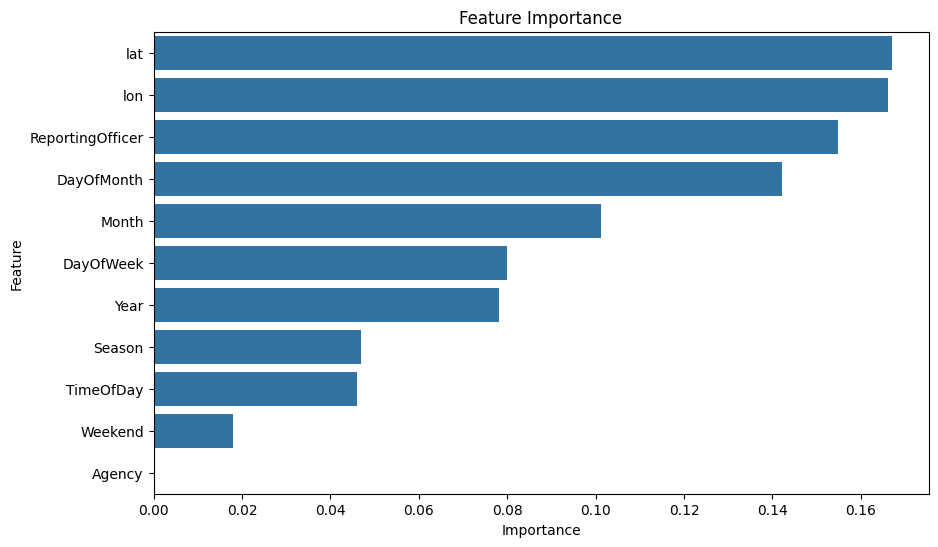

In [23]:
# For RandomForest or DecisionTree models, we can check feature importance
if isinstance(best_model, RandomForestClassifier) or isinstance(best_model, DecisionTreeClassifier):
    feature_importance = best_model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plotting the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title("Feature Importance")
    plt.show()


### Evaluation

After training the models and examining their performance, we evaluate the chosen model based on metrics like accuracy, precision, recall, and F1 score.



In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, Recall, F1 Score for each class (Offense Type)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.2874
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.36      0.32       576
           1       0.26      0.23      0.25       400
           2       0.32      0.48      0.38       680
           3       0.23      0.18      0.20       467
           4       0.28      0.20      0.23       336
           5       0.28      0.21      0.24       530
           6       0.28      0.23      0.26       477

    accuracy                           0.29      3466
   macro avg       0.28      0.27      0.27      3466
weighted avg       0.28      0.29      0.28      3466

Confusion Matrix:
[[206  61 142  42  21  60  44]
 [ 94  93  99  26  20  35  33]
 [109  54 325  56  27  63  46]
 [ 73  34 131  82  41  44  62]
 [ 43  24  85  44  67  32  41]
 [104  49 130  57  23 111  56]
 [ 73  40 115  49  38  50 112]]
Precision: 0.2816
Recall: 0.2874
F1 Score: 0.2783


#### For Logistic Regression (Coefficient Interpretation)

For Logistic Regression, the model coefficients can help us understand how each feature affects the likelihood of an offense happening. A positive coefficient indicates a feature increases the likelihood of the offense, and a negative coefficient indicates the opposite.

In [25]:
if isinstance(best_model, LogisticRegression):
    # Logistic regression coefficients
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_model.coef_[0]
    })
    coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)
    
    # Plotting the coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x='AbsCoefficient', y='Feature', data=coef_df)
    plt.title("Logistic Regression Coefficients Impact")
    plt.show()

    # Print the top 5 most impactful features (by absolute coefficient value)
    print("Top 5 most impactful features based on coefficients:")
    print(coef_df.head())


Explanation of Output:

Feature Importance (Random Forest/Decision Tree): The bar plot will show how important each feature is in the decision-making process. Features at the top of the list are the most influential in predicting the occurrence of offenses.

Logistic Regression Coefficients: The bar plot will show the magnitude of the coefficients for each feature. Features with larger absolute values (either positive or negative) have a stronger impact on the model’s predictions. Positive coefficients increase the probability of an offense, while negative coefficients decrease it.